In [1]:
#import things
# import Libraries
# Built-in Python libraries
import os # functions for interacting w operating system

# 3rd-party libraries
import numpy as np # module for low-level scientific computing
import pymc3 as pm
import theano.tensor as tt
import pickle
import pylab as plt
from scipy import stats

import csv
import pandas as pd

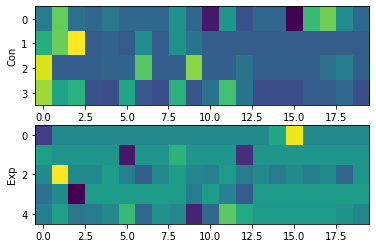

In [2]:
#Get name of directory where the data files and pickle file sits, and change to that directory for processing
dir_name = '/media/fastdata/brad_changepoint'
os.chdir(dir_name)

con_name = 'con_zscoreddiff_rearingduration.csv'
con_df = pd.read_csv(con_name,header=None)
con_data_mat = con_df.to_numpy()

exp_name = 'exp_zscoreddiff_rearingduration.csv'
exp_df = pd.read_csv(exp_name,header=None)
exp_data_mat = exp_df.to_numpy()


n_count_data = con_data_mat.shape[-1]
fig,ax = plt.subplots(2,1)
ax[0].imshow(con_data_mat,aspect='auto')
ax[0].set_ylabel('Con');
ax[1].imshow(exp_data_mat,aspect='auto')
ax[1].set_ylabel('Exp');

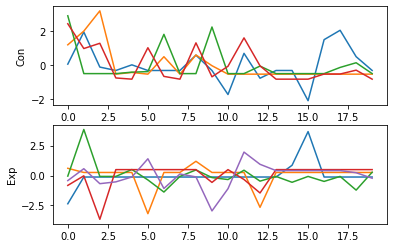

In [3]:
fig,ax = plt.subplots(2,1)
ax[0].plot(con_data_mat.T)
ax[0].set_ylabel('Con');
ax[1].plot(exp_data_mat.T)
ax[1].set_ylabel('Exp');

## Test Data

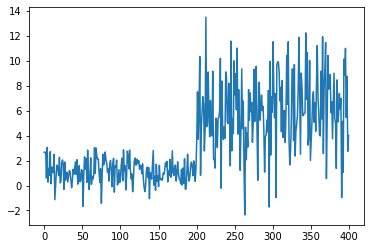

In [4]:
# Test data
length = 200
mu1 = 1
mu2 = 6
sigma1 = 1
sigma2 = 3

test_data = np.concatenate((stats.norm.rvs(mu1,sigma1,length),stats.norm.rvs(mu2,sigma2,length)))
plt.plot(test_data);


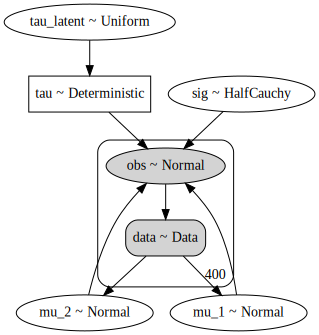

In [5]:
with pm.Model() as model:
    
    # Define shared "Data" holder to fit same model to different datasets 
    data = pm.Data("data", test_data)#con_data_mat[0])
    # Defining variables with priors
    alpha = data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    mu_1 = pm.Normal("mu_1", mu=alpha, sigma = 1)
    mu_2 = pm.Normal("mu_2", mu=alpha, sigma = 1)
    sigma = pm.HalfCauchy('sig', 1)

    idx = np.arange(np.array(model["data"].get_value()).shape[-1])
    
    # Uniform prior
    tau_latent = pm.Uniform('tau_latent', 0, 1)
    
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    
    # Using sigmoid rather than switch is supposed to be better
    # for sampler
    weight = tt.nnet.sigmoid(2 * (idx - tau))
    mu_ = (1 - weight) * mu_1 + weight * mu_2

with model:
    observation = pm.Normal("obs", mu=mu_, sigma = sigma, observed=data)

pm.model_to_graphviz(model)

In [6]:
with model:
        # Switch out the observed dataset
        pm.set_data({"data": test_data})
        test_trace = pm.sample()#pm.sample(step = pm.Metropolis())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2985.52draws/s]


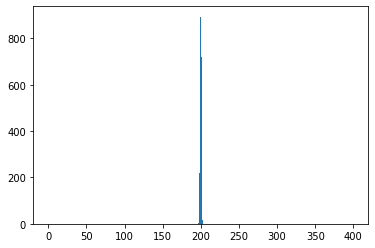

In [7]:
plt.hist(test_trace['tau'],np.arange(0,2*length));

## Actual Data

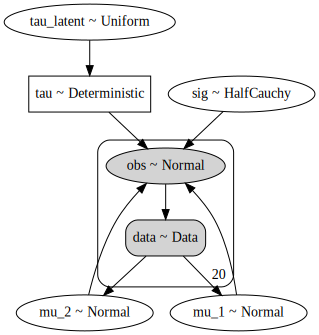

In [8]:
with pm.Model() as model:
    
    # Define shared "Data" holder to fit same model to different datasets 
    data = pm.Data("data", con_data_mat[0])
    # Defining variables with priors
    alpha = data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    mu_1 = pm.Normal("mu_1", mu=alpha, sigma = 1)
    mu_2 = pm.Normal("mu_2", mu=alpha, sigma = 1)
    sigma = pm.HalfCauchy('sig', 1)

    idx = np.arange(np.array(model["data"].get_value()).shape[-1])
    
    # Uniform prior
    tau_latent = pm.Uniform('tau_latent', 0, 1)
    
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    
    # Using sigmoid rather than switch is supposed to be better
    # for sampler
    weight = tt.nnet.sigmoid(2 * (idx - tau))
    mu_ = (1 - weight) * mu_1 + weight * mu_2

with model:
    observation = pm.Normal("obs", mu=mu_, sigma = sigma, observed=data)

pm.model_to_graphviz(model)

In [9]:
# Generate one trace for each dataset
con_traces = []
for data_vals in con_data_mat:
    with model:
        # Switch out the observed dataset
        pm.set_data({"data": data_vals})
        con_traces.append(pm.sample())#pm.sample(step = pm.Metropolis()))
        
# Generate one trace for each dataset
exp_traces = []
for data_vals in exp_data_mat:
    with model:
        # Switch out the observed dataset
        pm.set_data({"data": data_vals})
        exp_traces.append(pm.sample())#pm.sample(step = pm.Metropolis()))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2250.39draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2794.13draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2207.53draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing

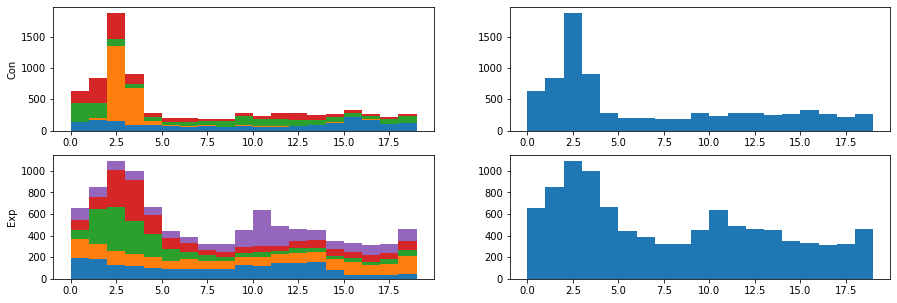

In [39]:
con_tau_array = np.array([this_trace["tau"] for this_trace in con_traces])
exp_tau_array = np.array([this_trace["tau"] for this_trace in exp_traces])

fig, ax = plt.subplots(2,2, figsize = (15,5))
ax[0,0].hist(con_tau_array.T, np.arange(20), stacked = 'true');
ax[0,1].hist(con_tau_array.flatten(), np.arange(20), stacked = 'true');
ax[1,0].hist(exp_tau_array.T, np.arange(20), stacked = 'true');
ax[1,1].hist(exp_tau_array.flatten(), np.arange(20), stacked = 'true');

ax[0,0].set_ylabel('Con');
ax[1,0].set_ylabel('Exp');

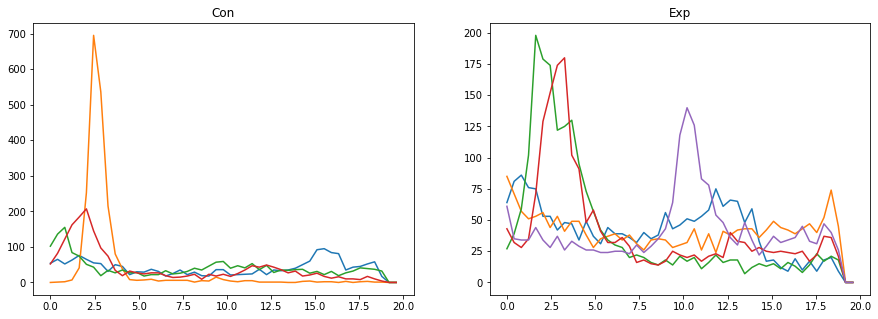

In [41]:
bins = np.linspace(0,20,50)
con_tau_hist = np.array([np.histogram(x, bins)[0] for x in con_tau_array])
exp_tau_hist = np.array([np.histogram(x, bins)[0] for x in exp_tau_array])

fig, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].plot(bins[:-1],con_tau_hist.T);
ax[1].plot(bins[:-1],exp_tau_hist.T);

ax[0].set_title('Con');
ax[1].set_title('Exp');

In [16]:
## What if we take out the first 5 minutes to avoid the transient in the beginning?

In [21]:
con_data_mat_cut = con_data_mat[:,5:]
exp_data_mat_cut = exp_data_mat[:,5:]

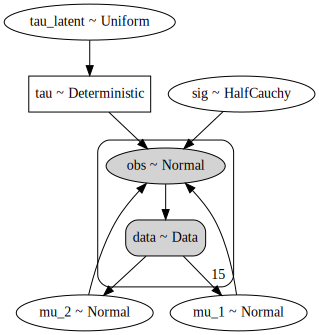

In [24]:
with pm.Model() as model_cut:
    
    # Define shared "Data" holder to fit same model to different datasets 
    data = pm.Data("data", con_data_mat_cut[0])
    # Defining variables with priors
    alpha = data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    mu_1 = pm.Normal("mu_1", mu=alpha, sigma = 1)
    mu_2 = pm.Normal("mu_2", mu=alpha, sigma = 1)
    sigma = pm.HalfCauchy('sig', 1)

    idx = np.arange(np.array(model_cut["data"].get_value()).shape[-1])
    
    # Uniform prior
    tau_latent = pm.Uniform('tau_latent', 0, 1)
    
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    
    # Using sigmoid rather than switch is supposed to be better
    # for sampler
    weight = tt.nnet.sigmoid(2 * (idx - tau))
    mu_ = (1 - weight) * mu_1 + weight * mu_2


    observation = pm.Normal("obs", mu=mu_, sigma = sigma, observed=data)

pm.model_to_graphviz(model_cut)

In [26]:
# Generate one trace for each dataset
con_traces_cut = []
for data_vals in con_data_mat_cut:
    with model_cut:
        # Switch out the observed dataset
        pm.set_data({"data": data_vals})
        con_traces_cut.append(pm.sample())#pm.sample(step = pm.Metropolis()))
        
# Generate one trace for each dataset
exp_traces_cut = []
for data_vals in exp_data_mat_cut:
    with model_cut:
        # Switch out the observed dataset
        pm.set_data({"data": data_vals})
        exp_traces_cut.append(pm.sample())#pm.sample(step = pm.Metropolis()))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2238.10draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2323.03draws/s]
The acceptance probability does not match the target. It is 0.92502389389496, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7150093846559284, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_lat

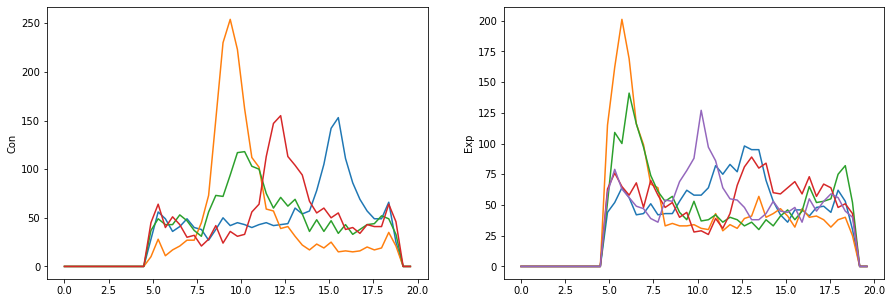

In [42]:
con_tau_array = np.array([this_trace["tau"] for this_trace in con_traces_cut])+5
exp_tau_array = np.array([this_trace["tau"] for this_trace in exp_traces_cut])+5
con_tau_hist = np.array([np.histogram(x, bins)[0] for x in con_tau_array])
exp_tau_hist = np.array([np.histogram(x, bins)[0] for x in exp_tau_array])

fig, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].plot(bins[:-1],con_tau_hist.T);
ax[1].plot(bins[:-1],exp_tau_hist.T);

ax[0].set_ylabel('Con');
ax[1].set_ylabel('Exp');